# Prototyping fashion category parsing with U-Net

## Intro

In [16]:
import numpy as np
#import pandas as pd

from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image

from matplotlib import gridspec

import h5py

## How to load and use fashion data

__Load data__

In [3]:
#filepath = '/Users/suzukiry/Downloads/tmm_dataset_sharing/fashon_parsing_data.mat'
filepath = './input/fashon_parsing_data.mat'

arrays = {}

f = h5py.File(filepath)

for k, v in f.items():
    arrays[k] = np.array(v)

/Users/suzukiry/lab/virtualenv/dev/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
arrays.keys()

dict_keys(['#refs#', 'all_category_name', 'all_colors_name', 'fashion_dataset'])

(600, 400, 3)
cat (1, 425)
col (1, 425)
seg (400, 600)


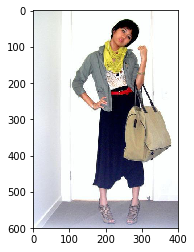

In [5]:
REF_CODE = '0C'

PICTURE_NAME = f['#refs#'][REF_CODE]['img_name'].value.tostring().decode('utf-8').replace('\x00', '')

list(f['#refs#'][REF_CODE])

cat=f['#refs#'][REF_CODE]['category_label'][:]
col=f['#refs#'][REF_CODE]['color_label'][:]
seg=f['#refs#'][REF_CODE]['segmentation'][:]

path="./input/image/"
im = Image.open(path+PICTURE_NAME) 

#im_rotate = im.rotate(90, expand=True)
im_rotate=im

plt.imshow(np.asarray(im_rotate))
print(np.asarray(im_rotate).shape)

print("cat {}".format(cat.shape))
print("col {}".format(col.shape))
print("seg {}".format(seg.shape))  

__Color variation and Category variation__

In [7]:
col_dic = {}

for col_i in range(len(arrays['all_colors_name'][-1])):
    print(str(col_i)+": "+np.array(f[arrays['all_colors_name'][0,col_i]]).tostring().decode('utf-8').replace('\x00', ''))
    col_dic[col_i] = str(np.array(f[arrays['all_colors_name'][0,col_i]]).tostring().decode('utf-8').replace('\x00', ''))

0: bk
1: beige
2: black
3: blue
4: brown
5: gray
6: green
7: orange
8: pink
9: purple
10: red
11: white
12: yellow


In [8]:
cat_dic = {}

for cat_i in range(len(arrays['all_category_name'][-1])):
    print(str(cat_i)+": "+np.array(f[arrays['all_category_name'][0,cat_i]]).tostring().decode('utf-8').replace('\x00', ''))
    cat_dic[cat_i] = str(np.array(f[arrays['all_category_name'][0,cat_i]]).tostring().decode('utf-8').replace('\x00', ''))

0: bk
1: T-shirt
2: bag
3: belt
4: blazer
5: blouse
6: coat
7: dress
8: face
9: hair
10: hat
11: jeans
12: legging
13: pants
14: scarf
15: shoe
16: shorts
17: skin
18: skirt
19: socks
20: stocking
21: sunglass
22: sweater


In [9]:
cat_apparel_dic = {
    1: "T-shirt",
    2: "bag",
    3: "belt",
    4: "blazer",
    5: "blouse",
    6: "coat",
    7: "dress",
    10: "hat",
    11: "jeans",
    12: "legging",
    13: "pants",
    14: "scarf",
    15: "shoe",
    16: "shorts",
    18: "skirt",
    19: "socks",
    20: "stocking",
    21: "sunglass",
    22: "sweater"}

__Check category of target picutre__

In [10]:
# image with category ID
cat_seg = []

for row in seg.copy():
    for test_i in row:
        cat_seg.append(int(cat[0][int(test_i)])-1)
        
cat_seg = np.array(cat_seg)
cat_seg = cat_seg.reshape(400,600)

In [12]:
# image with color ID
col_seg = []

for row in seg.copy():
    for test_i in row:
        col_seg.append(int(col[0][int(test_i)])-1)
        
col_seg = np.array(col_seg)
col_seg = col_seg.reshape(400,600)

__Utility function__

In [13]:
def create_pascal_label_colormap(type='fixed'):
    '''
    Create pascal label and colormap    
    0: bk
    1: beige
    2: black
    3: blue
    4: brown
    5: gray
    6: green
    7: orange
    8: pink
    9: purple
    10: red
    11: white
    12: yellow
    '''
    
    if type == 'random':
        colormap = np.zeros((256, 3), dtype=int)
        ind = np.arange(256, dtype=int)

        for shift in reversed(range(8)):
            for channel in range(3):
                colormap[:, channel] |= ((ind >> channel) & 1) << shift
            ind >>= 3
        #print(colormap)
        #print(colormap.shape)
        

    else: 
        bk = [153, 204, 255]
        beige = [255, 189, 128]
        black = [0, 0, 0]
        blue = [0, 0, 255]
        brown = [204, 102, 0]
        gray = [128, 128, 128]
        green = [128, 255, 0]
        orange = [255, 128, 0]
        pink = [255, 0, 255]
        purple = [128, 0, 255]
        red = [255, 64, 0]
        white = [255, 230, 230]
        yellow = [255, 255, 0]

        bk = np.array([bk])
        beige = np.array([beige])
        black = np.array([black])
        blue = np.array([blue])
        brown = np.array([brown])
        gray = np.array([gray])
        green = np.array([green])
        orange = np.array([orange])
        pink = np.array([pink])
        purple = np.array([purple])
        red = np.array([red])
        white = np.array([white])
        yellow = np.array([yellow])

        colormap = np.vstack((bk,beige,black,blue,brown,gray,green,orange,pink,purple,red,white,yellow))

    return colormap

In [14]:
def label_to_color_image(label):

    '''
    Return RGB correspondin to label
    '''

    if label.ndim != 2:
        raise ValueError('Expect 2-D input label')
    
    colormap = create_pascal_label_colormap("random")

    if np.max(label) >= len(colormap):
        raise ValueError('label value too large.')

    return colormap[label]

In [15]:
CAT_LABEL_NAMES = np.asarray([cat_dic[x] for x in range(len(cat_dic))])
FULL_CAT_LABEL_MAP = np.arange(len(CAT_LABEL_NAMES)).reshape(len(CAT_LABEL_NAMES), 1)
FULL_CATEGORY_MAP = label_to_color_image(FULL_CAT_LABEL_MAP)

for c in np.unique(cat_seg):
    #print(c, str(np.array(f[arrays['all_colors_name'][0,int(c)]]).tostring().decode('utf-8').replace('\x00', '')))
    cat_dic[c] = str(np.array(f[arrays['all_category_name'][0,int(c)]])
                     .tostring().decode('utf-8').replace('\x00', ''))

unique_labels = np.unique(cat_seg)

In [17]:
def vis_segmentation(image, seg_map):
    plt.figure(figsize=(15, 5))
    grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

    plt.subplot(grid_spec[0])
    plt.imshow(image)
    plt.axis('off')
    plt.title('input image')

    plt.subplot(grid_spec[1])
    seg_image = label_to_color_image(seg_map).astype(np.uint8) ## To do
    plt.imshow(seg_image)
    plt.axis('off')
    plt.title('segmentation map')
    
    plt.subplot(grid_spec[2])
    plt.imshow(image)
    plt.imshow(seg_image, alpha=0.7)
    plt.axis('off')
    plt.title('segmentation overlay')

    unique_labels = np.unique(seg_map)
    ax = plt.subplot(grid_spec[3])
    plt.imshow(
        FULL_CATEGORY_MAP[unique_labels].astype(np.uint8), interpolation='nearest') ## To do

    ax.yaxis.tick_right()
    plt.yticks(range(len(unique_labels)), CAT_LABEL_NAMES[unique_labels])
    plt.xticks([], [])
    ax.tick_params(width=0.0)
    plt.grid('off')
    plt.show()

/Users/suzukiry/lab/virtualenv/dev/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


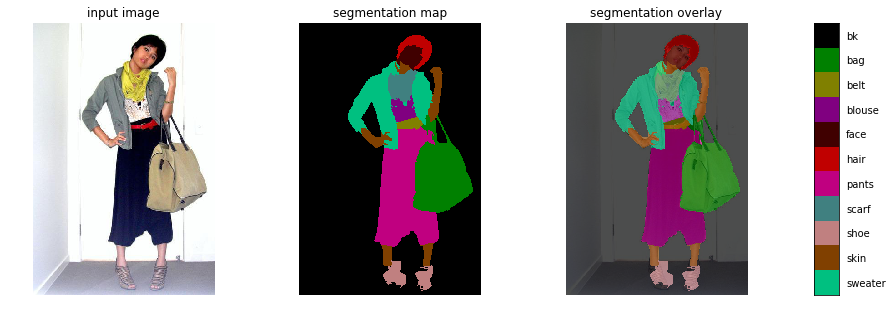

In [18]:
vis_segmentation(np.asarray(im_rotate),cat_seg.T)

In [19]:
cat_unique_list = np.unique(cat_seg)

def cat_id_to_color_id(cat_label,cat_seg,col_seg):
    '''Replace Category label with Color label'''
  
    pixel_x=np.where(cat_seg == cat_label)[0]
    pixel_y=np.where(cat_seg == cat_label)[1]
    
    return col_seg[pixel_x[0],pixel_y[0]]

cat_allocation_list = []

# Segmentation allocation by cateory ID 
for x in range(len(cat_unique_list)):
    cat_id = cat_unique_list[x]
    col_id = cat_id_to_color_id(cat_id,cat_seg,col_seg)
    cat_allocation_list.append([cat_id,np.sum(cat_seg == cat_id)])

    print(cat_dic[cat_id],np.sum(cat_seg == cat_id),col_dic[col_id])
    

bk 167214 bk
bag 17037 beige
belt 1079 red
blouse 2072 white
face 2053 beige
hair 2398 black
pants 22316 blue
scarf 3215 yellow
shoe 3208 gray
skin 5893 beige
sweater 13515 gray


In [20]:
# Picture size is 24,000
target_user_total = 0

for cat_i in range(len(cat_allocation_list)):
    if cat_allocation_list[cat_i][0] in cat_apparel_dic:
        target_user_total = target_user_total + cat_allocation_list[cat_i][1]
print(target_user_total)

62442


# Get the data

In [26]:
def add_margin(pil_img, top, right, bottom, left, color):
    width, height = pil_img.size
    new_width = width + right + left
    new_height = height + top + bottom
    result = Image.new(pil_img.mode, (new_width, new_height), color)
    result.paste(pil_img, (left, top))
    return result

def seg_to_cat(seg,cat):
    # Update seg image to cat image with category ID
    cat_seg = []

    for row in seg:
        for i in row:
            #print(type(i))
            cat_seg.append(int(cat[0][int(i)])-1)

    cat_seg = np.array(cat_seg)
    cat_seg = cat_seg.reshape(IMG_HEIGHT, IMG_WIDTH)
    
    return cat_seg

In [21]:
# Set parameters
IMG_WIDTH = 400
IMG_HEIGHT = 608 #608#592
IMG_CHANNELS = 3
IMG_SEGMENTATION = 425
#TRAIN_PATH = '../input/stage1_train/'
#TEST_PATH = '../input/stage1_test/'

# Set some parameters
#IMG_WIDTH = 400
#IMG_HEIGHT = 608
#IMG_CHANNELS = 3
N_Cls=23
'''
0: bk
1: T-shirt
2: bag
3: belt
4: blazer
5: blouse
6: coat
7: dress
8: face
9: hair
10: hat
11: jeans
12: legging
13: pants
14: scarf
15: shoe
16: shorts
17: skin
18: skirt
19: socks
20: stocking
21: sunglass
22: sweater
'''

'\n0: bk\n1: T-shirt\n2: bag\n3: belt\n4: blazer\n5: blouse\n6: coat\n7: dress\n8: face\n9: hair\n10: hat\n11: jeans\n12: legging\n13: pants\n14: scarf\n15: shoe\n16: shorts\n17: skin\n18: skirt\n19: socks\n20: stocking\n21: sunglass\n22: sweater\n'

In [22]:
# Get train and test IDs

ids = list(arrays['#refs#'])

#train_ids = next(os.walk(TRAIN_PATH))[1]

In [23]:
# Train : Valid : Test = 0.72 : 0.08 : 0.2

train_ratio=0.8 * 0.9
valid_ratio=0.8 * 0.1
test_ratio=0.2

train_data_count=int(len(ids) * train_ratio)
valid_data_count=int(len(ids) * valid_ratio)
test_data_count=len(ids)-train_data_count-valid_data_count

train_ids=ids[:train_data_count]
valid_ids=ids[train_data_count:train_data_count+valid_data_count]
test_ids=ids[train_data_count+valid_data_count:]

In [ ]:
from keras.preprocessing.image import load_img
from skimage.transform import resize
import sys

# Get and resize train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, N_Cls))
Y_original = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, N_Cls))
col_train = np.zeros((len(train_ids), 1, IMG_SEGMENTATION))
cat_train = np.zeros((len(train_ids), 1, IMG_SEGMENTATION))

X_valid = np.zeros((len(valid_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_valid = np.zeros((len(valid_ids), IMG_HEIGHT, IMG_WIDTH, N_Cls))
col_valid = np.zeros((len(valid_ids), 1, IMG_SEGMENTATION))
cat_valid = np.zeros((len(valid_ids), 1, IMG_SEGMENTATION))

print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    REF_CODE=id_
    
    if(type(f['#refs#'][id_]) is h5py._hl.dataset.Dataset):
        continue
    else:
        #print(REF_CODE,len(list(f['#refs#'][id_])))
        PICTURE_NAME = f['#refs#'][REF_CODE]['img_name'].value.tostring().decode('utf-8').replace('\x00', '')

        seg=f['#refs#'][REF_CODE]['segmentation'][:]
        cat=f['#refs#'][REF_CODE]['category_label'][:]
        col=f['#refs#'][REF_CODE]['color_label'][:]

        path="./input/image/"
        #img = load_img(path+PICTURE_NAME, target_size=(IMG_HEIGHT, IMG_WIDTH))
        im = Image.open(path+PICTURE_NAME) 
        
        im=add_margin(im,0,0,8,0,(0, 0, 0))
        X_train[n] = im
        
        seg = seg.T

        # Add 8pix at the bottom
        for i in range(8):
            seg=np.r_[seg,[seg[599,:]]]
        
        
        #seg = resize(seg, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)

        seg = seg[:,:,np.newaxis]
        
        Y_train[n] = seg
        Y_original[n] = seg
        
        col_train[n] = col
        cat_train[n] = cat
        
        cat_seg = seg_to_cat(Y_train[n][:,:,0],cat_train[n])       
        for n_cls in range(N_Cls):
            Y_train[n,:,:,n_cls] = np.where(cat_seg == n_cls, 1, 0)
        
for n, id_ in tqdm(enumerate(valid_ids), total=len(valid_ids)):
    REF_CODE=id_
    if(type(f['#refs#'][id_]) is h5py._hl.dataset.Dataset):
        continue
    else:
        #print(REF_CODE,len(list(f['#refs#'][id_])))
        PICTURE_NAME = f['#refs#'][REF_CODE]['img_name'].value.tostring().decode('utf-8').replace('\x00', '')

        seg=f['#refs#'][REF_CODE]['segmentation'][:]
        cat=f['#refs#'][REF_CODE]['category_label'][:]
        col=f['#refs#'][REF_CODE]['color_label'][:]

        path="./input/image/"
        #img = load_img(path+PICTURE_NAME, target_size=(IMG_HEIGHT, IMG_WIDTH))
        im = Image.open(path+PICTURE_NAME) 

        im=add_margin(im,0,0,8,0,(0, 0, 0))
        X_valid[n] = im
        
        seg = seg.T
        
        # Add 8pix at the bottom
        for i in range(8):
            seg=np.r_[seg,[seg[599,:]]] #Accumulate row 599 times 8
                
        #seg = resize(seg, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        seg = seg[:,:,np.newaxis]
        
        Y_valid[n] = seg
        col_valid[n] = col
        cat_valid[n] = cat

        cat_seg = seg_to_cat(Y_valid[n][:,:,0],cat_valid[n])       
        for n_cls in range(N_Cls):
            Y_valid[n,:,:,n_cls] = np.where(cat_seg == n_cls, 1, 0)

print('Done!')

Using TensorFlow backend.


Getting and resizing test images ... 


 38%|███▊      | 736/1957 [04:15<07:04,  2.88it/s]

In [ ]:
Y_train.shape

In [ ]:
Y_train[0].shape

In [ ]:
n = 0

In [ ]:
test = seg_to_cat(Y_train[n][:,:,0],cat_train[n])

stacked_seg = np.zeros((IMG_HEIGHT, IMG_WIDTH, N_Cls), dtype=np.uint8)
print(stacked_seg.shape)

for n_cls in range(N_Cls):
    stacked_seg[:,:,n_cls] = np.where(test == n_cls, 1, 0)
    #Y_train[n,:,:,n_cls] = np.where(test == n_cls, 1, 0)


In [ ]:
def imshow_with_title(ax, img, title):
        ax.imshow(img / 255.)
        ax.set_title(title)
        ax.axis('off')
        return ax

In [ ]:
Y_train.shape

In [ ]:
import math
test_seg_no = 0
n = N_Cls
ncols=5

nrows = math.ceil(n / ncols)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3 * ncols, 3 * nrows))

for i, ax in enumerate(axes.ravel()):    
    if i >= N_Cls:
        break
    #ax = imshow_with_title(ax, stacked_seg[:,:,i], cat_dic[i]) 
    ax = imshow_with_title(ax, Y_train[test_seg_no,:,:,i], cat_dic[i]) 


In [ ]:
for n_cls in range(N_Cls):
    print(cat_dic[n_cls],np.sum(Y_train[test_seg_no,:,:,n_cls] == 1)) 

In [ ]:
plt.imshow(X_train[test_seg_no])

In [ ]:
one = np.ones((1,3,4))

In [ ]:
zero = np.zeros((1,3,4))

In [ ]:
np.dstack((one,zero))

In [ ]:
print(X_train.shape, Y_train.shape, np.amax(X_train), np.amin(X_train), np.amax(Y_train), np.amin(Y_train))

In [ ]:
vis_segmentation(np.asarray(X_train[0]),seg_to_cat(Y_original[0][:,:,0],cat_train[0]))

# Create our Keras metric

In [43]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

# Build and train our neural network

In [44]:
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf


In [45]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs) #0〜1の範囲に正規化

# Contracting 1
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (s)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

# Contracting 2
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

# Contracting 3
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

# Contracting 4
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

# Lowest resolution
c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

# Up-sampling 1
u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

# Up-sampling 2
u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

# Up-sampling 3
u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

# Up-sampling 4
u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

outputs = Conv2D(N_Cls, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
model.summary()

Instructions for updating:
keep_dims is deprecated, use keepdims instead
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 608, 400, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 608, 400, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 608, 400, 8)  224         lambda_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 608, 400, 8)  584         conv2d_1[0][0]                   
____________________________________

In [46]:
# Fit model
EPOCHS = 1

earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-fashion2018-1.h5', verbose=1, save_best_only=True)

In [47]:
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=8, epochs=EPOCHS, 
                    callbacks=[earlystopper, checkpointer])

Train on 72 samples, validate on 9 samples
Epoch 1/1
72/72 [==============================] - 173s 2s/step - loss: 0.6819 - mean_iou: 0.4133 - val_loss: 0.6563 - val_mean_iou: 0.4677


In [48]:
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img


  0%|          | 0/2584 [00:00<?, ?it/s]


NameError: name 'TEST_PATH' is not defined

In [ ]:
X_train.shape

In [34]:
REF_CODE='0G'

In [35]:
col=f['#refs#'][REF_CODE]['color_label'][:]
seg=f['#refs#'][REF_CODE]['segmentation'][:]

In [36]:
seg.copy()

array([[  0.,   0.,   0., ...,  24.,  24.,  24.],
       [  0.,   0.,   0., ...,  24.,  24.,  24.],
       [  0.,   0.,   0., ...,  24.,  24.,  24.],
       ...,
       [400., 400., 400., ..., 424., 424., 424.],
       [400., 400., 400., ..., 424., 424., 424.],
       [400., 400., 400., ..., 424., 424., 424.]], dtype=float32)

In [37]:
seg.copy().shape

(400, 600)

In [70]:
col.shape

(1, 425)

In [71]:
# image with color ID
col_seg = []

for row in seg.copy():
    for col_i in row:
        col_seg.append(int(col[0][int(col_i)])-1)


col_seg = np.array(col_seg)
col_seg = col_seg.reshape(400,600)

AttributeError: 'list' object has no attribute 'shape'

In [66]:
col_unique_list = np.unique(col_seg)

In [67]:
col_unique_list

array([ 0,  1,  2,  4,  8, 11])

In [68]:
col_seg

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

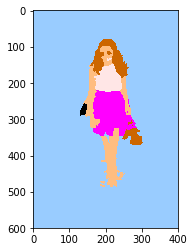

In [69]:
seg_image = label_to_color_image(col_seg.T).astype(np.uint8)
plt.imshow(seg_image)

In [ ]:
# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img


In [31]:
X_train.shape

(2120, 600, 400, 3)

In [ ]:
mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    mask_ = mask
    mask = np.maximum(mask, mask_)
    Y_train[n] = mask


In [108]:
REF_CODE=train_ids[0]

PICTURE_NAME = f['#refs#'][REF_CODE]['img_name'].value.tostring().decode('utf-8').replace('\x00', '')

cat=f['#refs#'][REF_CODE]['category_label'][:]
col=f['#refs#'][REF_CODE]['color_label'][:]
seg=f['#refs#'][REF_CODE]['segmentation'][:]

path="./input/image/"
im = Image.open(path+PICTURE_NAME) 

X_train[0]=im

#im_rotate = im.rotate(90, expand=True)
im_rotate=im

#plt.imshow(np.asarray(im_rotate))





In [109]:
seg.shape

(400, 600)

In [ ]:
# Get and resize train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask